# Churn - Feature Engineering

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

DEBUG = False
TRAIN_TEST_SEED = 76

In [2]:
import os
for d in ['src','data','output']: os.makedirs(d, exist_ok=True)

In [3]:
from IPython.display import Markdown, display

In [4]:
# utility funciton for typesetting percentages
display_fraction = lambda n,d: (n/d*100, n, d)

## Load and Prepare the Data 

I have made a slight change of naming convention which will simply code below - and also avoid mistakes in lab sessions when I rerun cells out of order to demo parts of the code.   Rather than using __df__ to store the full dataset I will use __df_all__, and use __df__ as an alias for various dataset as needed - see [Feature Engineering](#Feature_Engineering). So will try to follow naming convention:

 * __df__ alias for various datasets (trwated link a tmp variable, more later). 
 * __df_all__ full dataset after loading and prepped (columns renamed, value recoded).
 * __df_model__ dataset with target and a subset of the original attributes that may appear in model or be used to construct other attributes.
 * __df_train__ dataset 
 * __df_test__ dataset 

 


In [5]:
df_churn = pd.read_csv("data/churn.csv")
print("Churn", df_churn.shape)
df_states = pd.read_csv("data/states.csv")
print("States", df_states.shape)

df_all = df_churn.merge(df_states, on="State")

message = (" * Data set consists of %d cases (rows) with %s attributes (cols) and a single target."  
% (df_all.shape[0], df_all.shape[1]-1))
Markdown(message)

Churn (3333, 20)
States (52, 4)


 * Data set consists of 3333 cases (rows) with 22 attributes (cols) and a single target.

## Pre-Processing Data

In [6]:
target = "Churn"
attributes = df_all.columns.tolist()
attributes.remove(target) 

df_model = df_all.loc[:, attributes + [target]]

### Side Note - Down-Sampling 

When a dataset is imbalanced, one can generate a balanced dataset by taking a sample of the larger set.

In [7]:
#df_balanced_down_sampling = pd.concat ([
#    df_all[df_all.Churn==0].sample(n=sum(df_all.Churn==1), random_state=TRAIN_TEST_SEED),
#    df_all[df_all.Churn==1]])

### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.40, random_state=TRAIN_TEST_SEED)
print(df_train.shape, df_test.shape)

(1999, 23) (1334, 23)


In [9]:
# save copy of df_train for use with dtale
df_train.to_csv("data/dt_train.csv", index=False)

## Feature_Engineering 

Features engineering and selection decision is carried out on __df_train__ ONLY, but resulting operations should be applied to both __df_train__ and __df_test__. The simplest way to do this (without repeating code) is to apply operations to __df_model__ and repeat the train/test split USING THE SAME SEED.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [10]:
my_query = df_train.query('CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
my_query.head()

,State,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Latitude,Longitude,Name,Churn
3219,CT,106,510,0,1,33,81.6,120,13.87,235.6,85,20.03,150.9,113,6.79,9.9,4,2.67,1,41.603221,-73.087749,Connecticut,0
873,MT,130,408,0,1,19,152.9,87,25.99,213.2,99,18.12,205.3,114,9.24,10.8,6,2.92,2,46.879682,-110.362566,Montana,0
1662,HI,166,408,0,0,0,181.4,108,30.84,253.8,54,21.57,112.3,94,5.05,11.6,6,3.13,1,19.898682,-155.665857,Hawaii,0
973,ID,85,408,0,1,27,196.4,139,33.39,280.9,90,23.88,89.3,75,4.02,13.8,4,3.73,1,44.068202,-114.742041,Idaho,0
602,WV,75,415,0,0,0,111.7,121,18.99,237.3,119,20.17,253.5,110,11.41,13.1,6,3.54,1,38.597626,-80.454903,West Virginia,0


In [11]:
df_model["Cranky_Triskaidekaphobias"] = df_model.apply (lambda row: (row.CustServ_Calls>0 
            and row.Day_Calls!=13 and row.Eve_Calls!=13 
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

In [12]:
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias'],
      dtype='object')

### New Feature - Total Charge
Is the sum of all Charges for a user

In [13]:
df_model["total_charge"] = df_model.apply (lambda row: (row.Day_Charge +  row.Eve_Charge + row.Night_Charge + row.Intl_Charge), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge'],
      dtype='object')

### New Feature - Total Mins
Is the sum of all minutes that the user has spent on calls

In [14]:
df_model["total_mins"] = df_model.apply (lambda row: (row.Day_Mins + 
            + row.Night_Mins + row.Eve_Mins + row.Intl_Mins), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins'],
      dtype='object')

### New Feature - Total Calls
Is the total number of calls that any customer has made

In [15]:
df_model["total_calls"] = df_model.apply (lambda row: (row.Day_Calls + 
            + row.Night_Calls + row.Eve_Calls + row.Intl_Calls), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls'],
      dtype='object')

### New Feature - Lower than average total calls with higher than average total charge
This feature finds users that make less than the average number of calls but get charge more than the average, the logic here being that users that are overcharged are more likely to churn


In [16]:
df_model["low_call_high_charge"] = df_model.apply (lambda row: (row.total_calls<(df_model.total_calls.sum()/df_model.total_calls.mean()) and row.total_charge>(df_model.total_charge.sum()/df_model.total_charge.mean())), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge'],
      dtype='object')

### New Feature - Higher than avg international charge
This feature shows whether the user is being charged more than the average person for international calls

In [17]:
df_model["intl_callers_higher_than_avg_charge"] = df_model.apply (lambda row: (row.Intl_Charge > df_model.Intl_Charge.mean() and row.Intl_Plan!=0), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge'],
      dtype='object')

### New Feature - International users with higher than average international calls
This feature shows whether a customer with a plan makes more calls internationally than the average number of calls of all users

In [18]:
df_model["intl_callers_higher_than_avg_calls"] = df_model.apply (lambda row: (row.Intl_Plan!=0 and row.Intl_Calls > df_model.Intl_Calls.mean()), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls'],
      dtype='object')

### New Feature - International caller with no International plan
This feature shows whether the customer uses international calls but doesn't have an international plan

In [19]:
df_model["intl_callers_no_plan"] = df_model.apply (lambda row: (row.Intl_Plan!=1 and row.Intl_Calls > 0), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan'],
      dtype='object')

### New Feature - Average charge per total_mins
This feature finds the average charge per minute for all of the customers calls

In [20]:
df_model["avg_charge_per_min"] = df_model.apply (lambda row: (row.total_charge/row.total_mins), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min'],
      dtype='object')

### New Feature - New Angry customer
This feature shows whether the customer might be angry if they are fairly new to the company and have made calls to customer service while being with the company for less than 50 units of account_length

In [21]:
df_model["new_n_angry"] = df_model.apply (lambda row: (row.Account_Length<50 and row.CustServ_Calls > 0), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min', 'new_n_angry'],
      dtype='object')

### New Feature - Average calls per account length
This feature finds the average number of calls per account_length (weeks or days?)

In [22]:
df_model["avg_calls_per_length"] = df_model.apply (lambda row: (row.total_calls/row.Account_Length), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min', 'new_n_angry', 'avg_calls_per_length'],
      dtype='object')

### New Feature - avg missed calls per day
This Feature finds the average number vmails/missed calls per account_length

In [23]:
df_model["avg_calls_per_acc_length"] = df_model.apply (lambda row: (row.VMail_Message/row.Account_Length), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min', 'new_n_angry', 'avg_calls_per_length',
       'avg_calls_per_acc_length'],
      dtype='object')

### New Feature - Avg Call Length
Finds the average number of minutes that the customer spent on calls

In [24]:
df_model["avg_call_length"] = df_model.apply (lambda row: (row.total_calls/row.total_mins), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min', 'new_n_angry', 'avg_calls_per_length',
       'avg_calls_per_acc_length', 'avg_call_length'],
      dtype='object')

### New Feature - Avg Charge per call
Finds the average charge per call for the customer

In [25]:
df_model["avg_call_length"] = df_model.apply (lambda row: (row.total_charge/row.total_calls), axis=1)
df_model.columns

Index(['State', 'Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan',
       'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins',
       'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge',
       'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Latitude',
       'Longitude', 'Name', 'Churn', 'Cranky_Triskaidekaphobias',
       'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge',
       'intl_callers_higher_than_avg_charge',
       'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan',
       'avg_charge_per_min', 'new_n_angry', 'avg_calls_per_length',
       'avg_calls_per_acc_length', 'avg_call_length'],
      dtype='object')

### New Feature - Avg Charge per call
Finds the whether the customer is statistically more probable to be a democrat or republican

In [26]:
Democrats = "CA,OR,WA,NV,CO,AZ,NM, MN,WI,MI,IL,PA,NY,VT,ME,NH,MA,CT,RI,NJ,DE,MD,VA,GA".split(",")
Republicans = "MT,ID,WY,UT,ND,SD,NE,KS,OK,TX,IA,MO,AR,LA,MS,AL,TN,KY,IN,OH,WV,NC,SC,FL".split(",")

df_model["Democrat"] = df_model.apply (lambda row: (row.State in Democrats), axis=1)

        

## Model Training

In [27]:
print (df_model.columns.values)

['State' 'Account_Length' 'Area_Code' 'Intl_Plan' 'VMail_Plan'
 'VMail_Message' 'Day_Mins' 'Day_Calls' 'Day_Charge' 'Eve_Mins'
 'Eve_Calls' 'Eve_Charge' 'Night_Mins' 'Night_Calls' 'Night_Charge'
 'Intl_Mins' 'Intl_Calls' 'Intl_Charge' 'CustServ_Calls' 'Latitude'
 'Longitude' 'Name' 'Churn' 'Cranky_Triskaidekaphobias' 'total_charge'
 'total_mins' 'total_calls' 'low_call_high_charge'
 'intl_callers_higher_than_avg_charge'
 'intl_callers_higher_than_avg_calls' 'intl_callers_no_plan'
 'avg_charge_per_min' 'new_n_angry' 'avg_calls_per_length'
 'avg_calls_per_acc_length' 'avg_call_length' 'Democrat']


### Train-Test Split

REPEAT train/test split from above so that both data subsets have the modified feature set.

In [28]:
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.40, random_state=TRAIN_TEST_SEED)
attributes = df_model.columns.tolist()
attributes.remove(target)
for c in ["Churn", "State", "Name", "Longitude", "Latitude"]: 
    if c in attributes: attributes.remove(c)

print(attributes)

['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Cranky_Triskaidekaphobias', 'total_charge', 'total_mins', 'total_calls', 'low_call_high_charge', 'intl_callers_higher_than_avg_charge', 'intl_callers_higher_than_avg_calls', 'intl_callers_no_plan', 'avg_charge_per_min', 'new_n_angry', 'avg_calls_per_length', 'avg_calls_per_acc_length', 'avg_call_length', 'Democrat']


In [29]:
df_model.loc[:,attributes].head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Cranky_Triskaidekaphobias,total_charge,total_mins,total_calls,low_call_high_charge,intl_callers_higher_than_avg_charge,intl_callers_higher_than_avg_calls,intl_callers_no_plan,avg_charge_per_min,new_n_angry,avg_calls_per_length,avg_calls_per_acc_length,avg_call_length,Democrat
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,True,75.56,717.2,303,False,False,False,True,0.105354,False,2.367188,0.195312,0.249373,False
1,70,408,0,0,0,232.1,122,39.46,292.3,112,24.85,201.2,112,9.05,0.0,0,0.00,3,True,73.36,725.6,346,False,False,False,False,0.101103,False,4.942857,0.000000,0.212023,False
2,92,408,1,0,0,62.6,111,10.64,180.6,126,15.35,221.7,80,9.98,10.4,2,2.81,1,True,38.78,475.3,319,False,True,False,False,0.081591,False,3.467391,0.000000,0.121567,False
3,137,408,0,0,0,205.9,88,35.00,209.3,86,17.79,289.9,84,13.05,14.5,4,3.92,2,True,69.76,719.6,262,False,False,False,True,0.096943,False,1.912409,0.000000,0.266260,False
4,132,415,0,0,0,83.4,110,14.18,232.2,137,19.74,146.7,114,6.60,7.6,5,2.05,1,True,42.57,469.9,366,False,False,False,True,0.090594,False,2.772727,0.000000,0.116311,False


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

### Evaluation

We used accuracy metric last week.  This week we will focus on recall - it is probably more relevant in this case and we want to focus on identifying as many Churn customers as possible.

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, roc_auc_score

models = []

### Training - First Iteration

Just a few of our standard classifiers, using default/semi-sane parameters.

In [32]:
models = []

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models.append( {"name": "LogisticRegression", "ref": LogisticRegression(solver="lbfgs")} )

# Support Vector Machines
from sklearn.svm import SVC
models.append( {"name": "SVC", "ref": SVC(gamma="scale")} )

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models.append( {"name": "DT (pruned=4)", "ref": DecisionTreeClassifier(criterion='entropy', max_depth=4)} )

print("Models:")
for model in models:
    print(f"    {model['name']:30} {model['ref']}")

Models:
    LogisticRegression             LogisticRegression()
    SVC                            SVC()
    DT (pruned=4)                  DecisionTreeClassifier(criterion='entropy', max_depth=4)


In [33]:
for model in models:
    
    crossval_scores = cross_val_score(model["ref"], X_train, y_train, scoring='recall', cv=10)
    print ("\nModel %s" % model["name"])
    print ("\tCV scores %s" % [f"{s:.4f}" for s in crossval_scores])
    print ("\tmean=%.4f std=%.4f" % (crossval_scores.mean(), crossval_scores.std()))


Model LogisticRegression
	CV scores ['0.2414', '0.2414', '0.3448', '0.2414', '0.3793', '0.3793', '0.2759', '0.1379', '0.3793', '0.1724']
	mean=0.2793 std=0.0837

Model SVC
	CV scores ['0.2069', '0.5172', '0.4483', '0.3793', '0.4483', '0.5172', '0.4138', '0.4138', '0.4828', '0.3103']
	mean=0.4138 std=0.0912

Model DT (pruned=4)
	CV scores ['0.6897', '0.6897', '0.7931', '0.6207', '0.7931', '0.6207', '0.6552', '0.6552', '0.6552', '0.7931']
	mean=0.6966 std=0.0669


### Feature Selection

In [34]:
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=TRAIN_TEST_SEED)

X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))

y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

Optimal number of features : 20


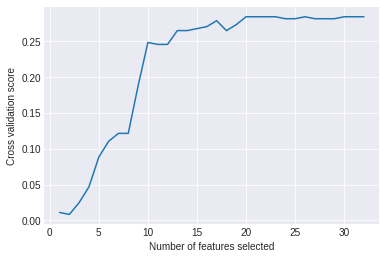

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

model = models[0]["ref"]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="recall")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [36]:
# list of features selected
attributes_selected = np.array(attributes)[rfecv.support_].tolist()
attributes_selected

['Intl_Plan',
 'VMail_Plan',
 'VMail_Message',
 'Day_Mins',
 'Day_Charge',
 'Eve_Mins',
 'Eve_Charge',
 'Night_Mins',
 'Night_Charge',
 'Intl_Mins',
 'Intl_Calls',
 'Intl_Charge',
 'CustServ_Calls',
 'Cranky_Triskaidekaphobias',
 'total_charge',
 'intl_callers_higher_than_avg_charge',
 'intl_callers_higher_than_avg_calls',
 'intl_callers_no_plan',
 'avg_charge_per_min',
 'avg_call_length']

### Training - After Feature Selection

In [37]:
df_model_fs = df_model.loc[:, attributes_selected + [target]]
display(df_model_fs.head())

# train-test split
df_train_fs, df_test_fs = train_test_split(df_model_fs, stratify=df_model_fs[target], test_size=.25, random_state=TRAIN_TEST_SEED)
attributes = df_model_fs.columns.tolist()
attributes.remove(target)

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

for model in models:
    
    crossval_scores = cross_val_score(model["ref"], X_train, y_train, scoring='recall', cv=5)
    print ("\nModel %s" % model["name"])
    print ("\tCV scores %s" % [f"{s:.4f}" for s in crossval_scores])
    print ("\tmean=%.4f std=%.4f" % (crossval_scores.mean(), crossval_scores.std()))

,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Charge,Eve_Mins,Eve_Charge,Night_Mins,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Cranky_Triskaidekaphobias,total_charge,intl_callers_higher_than_avg_charge,intl_callers_higher_than_avg_calls,intl_callers_no_plan,avg_charge_per_min,avg_call_length,Churn
0,0,1,25,265.1,45.07,197.4,16.78,244.7,11.01,10.0,3,2.70,1,True,75.56,False,False,True,0.105354,0.249373,0
1,0,0,0,232.1,39.46,292.3,24.85,201.2,9.05,0.0,0,0.00,3,True,73.36,False,False,False,0.101103,0.212023,0
2,1,0,0,62.6,10.64,180.6,15.35,221.7,9.98,10.4,2,2.81,1,True,38.78,True,False,False,0.081591,0.121567,1
3,0,0,0,205.9,35.00,209.3,17.79,289.9,13.05,14.5,4,3.92,2,True,69.76,False,False,True,0.096943,0.266260,0
4,0,0,0,83.4,14.18,232.2,19.74,146.7,6.60,7.6,5,2.05,1,True,42.57,False,False,True,0.090594,0.116311,0



Model LogisticRegression
	CV scores ['0.3750', '0.3750', '0.2603', '0.2877', '0.2361']
	mean=0.3068 std=0.0580

Model SVC
	CV scores ['0.5278', '0.5694', '0.5342', '0.4658', '0.6111']
	mean=0.5417 std=0.0482

Model DT (pruned=4)
	CV scores ['0.7500', '0.7639', '0.7123', '0.6986', '0.7361']
	mean=0.7322 std=0.0239
